<a href="https://colab.research.google.com/github/chedlyba/birdclef/blob/master/BNN_Meta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import tensor
from torchvision.datasets import MNIST
import math 
from torch import nn
from collections import OrderedDict
import json
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
from sklearn.model_selection import train_test_split


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def binarize(tensor):
    return tensor.sign()

class BinarizeLinearLayer(nn.Linear):
    def __init__(self, is_input=False, *kargs, **kwargs):
        super(BinarizeLinearLayer, self).__init__(*kargs, **kwargs)
        self.is_input = False


    def forward(self, input):
        if not self.is_input:
            input.data = binarize(input.data)
        if not hasattr(self.weight, 'org'): 
            self.weight.org = self.weight.data.clone() 
        self.weight.data = binarize(self.weight.org)
        out = nn.functional.linear(input, self.weight)
        if self.bias is not None:
            self.bias.org = self.bias.data.clone()
            out+= self.bias.view(1, -1).expand_as(out)
        
        return out
  
class BinarizeConv2d(nn.Conv2d):

    def __init__(self, *kargs, **kwargs):
        super(BinarizeConv2d, self).__init__(*kargs, **kwargs)
        self.is_input = False

    def forward(self, input):
        
        if not self.is_input:
            input.data = binarize(input.data)
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()
        self.weight.data=binarize(self.weight.org)

        out = torch.nn.functional.conv2d(input, self.weight, None, self.stride,
                                   self.padding, self.dilation, self.groups)

        if not self.bias is None:
            self.bias.org=self.bias.data.clone()
            out += self.bias.view(1, -1, 1, 1).expand_as(out)

        return out

class SignActivation(torch.autograd.Function):

    @staticmethod
    def forward(ctx, i):
        result = i.sign()
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i, = ctx.saved_tensors
        grad_i = grad_output.clone()
        grad_i [ i.abs() > 1.0 ] = 0
        return grad_i

In [ ]:
class Adam_meta(torch.optim.Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), meta = {}, eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, meta=meta, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(Adam_meta, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam_meta, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])


                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                

                binary_weight_before_update = torch.sign(p.data)
                condition_consolidation = (torch.mul(binary_weight_before_update, exp_avg) > 0.0 )   # exp_avg has the same sign as exp_avg/denom

                #decayed_exp_avg = torch.where(p.data.abs()>group['meta'], torch.zeros_like(p.data), exp_avg)

                if p.dim()==1: # True if p is bias, false if p is weight
                    p.data.addcdiv_(-step_size, exp_avg, denom)
                else:
                    decayed_exp_avg = torch.mul(torch.ones_like(p.data)-torch.pow(torch.tanh(group['meta']*torch.abs(p.data)),2), exp_avg)
                    #p.data.addcdiv_(-step_size, exp_avg , denom)  #normal update
                    p.data.addcdiv_(-step_size, torch.where(condition_consolidation, decayed_exp_avg, exp_avg), denom)  #assymetric lr for metaplasticity
                    
        return loss

In [ ]:
def load_dataset(data_path):
    with open(data_path, 'r') as fp:
        data = json.load(fp)
    # extract inputs and tagets

    X = torch.from_numpy(np.array(data['spectrogram']))
    y = data['bird']

    return X, y

def get_data_split(data_path):
    X, y = load_dataset(data_path)
    labels= pd.unique(y).tolist()
    l = []
    for birds in labels:
        for bird in birds.split(' '):
            l.append(bird)
    labels = pd.unique(l).tolist()
        
    # create train/validation/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.3)

    X_train = torch.swapaxes(X_train, 1, -1)
    X_validation = torch.swapaxes(X_validation, 1 ,-1)
    X_test = torch.swapaxes(X_test, 1, -1)

    return X_train, X_validation, X_test, y_train, y_validation, y_test, labels


def normalize(tensor):
  tensor_norm = tensor - tensor.mean()
  return tensor_norm / (tensor_norm.abs().max() + 1e-7)


class SoundDS(Dataset):
    def __init__(self, x, y, mappings, is_train=True, augment=1):
        self.x = []
        self.y = []
        augmented_data = []
        augmented_data_labels = []
        
        for data, label in zip(x, y):
          data = normalize(data)
          self.x.append(data)
          self.y.append(label)
          if is_train:
            if label != 'nocall': 
              for _ in range(augment):
                  new_data = (data + torch.unsqueeze(torch.randn(data.shape[1], data.shape[2])-torch.mean(data), 0))
                  augmented_data_labels.append(label)
                  augmented_data.append(new_data)
              
        self.x += augmented_data
        self.y += augmented_data_labels

        self.mappings = mappings
        self.num_classes = len(mappings.keys())
        print(f'Total items: {len(self.x)}')

    def __getitem__(self, idx):
        target = self.mappings[self.y[idx].split()[0]]
        return self.x[idx] , target

    def __len__(self):
        return len(self.x)



In [ ]:
def inference(model, val_dl):
    correct_pred = 0
    total_pred = 0
    preds = np.empty(shape=(1,))
    targets = np.empty(shape=(1,))
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data in val_dl:
            inputs, labels = data[0].float().to(DEVICE), data[1].long()
            outputs = model(inputs).to('cpu')
            
            loss = criterion(outputs, labels)
            _, prediction = torch.max(outputs,1)
            correct_pred += (prediction == labels).sum().item()
            
            total_pred += prediction.shape[0]
            
            preds = np.append(preds, prediction)
            targets = np.append(targets, labels)
    preds = preds[1:,...]
    targets = targets[1:,...]
    acc = correct_pred / total_pred
    print(f'Accuracy: {acc:.2f}, Loss: {loss:.2f}, Total items: {total_pred}')
    return preds, targets, acc

def train(model, train_dl, test_dl, lr=5e-03, epochs=50, optim='', meta=0.0, weight_decay=1e-07):
 
    criterion = nn.CrossEntropyLoss()
    if optim == 'meta':
        optimizer = Adam_meta(model.parameters(), lr=lr, meta=meta, weight_decay=1e-07)
    else :
        optimizer = torch.optim.Adam(model.parameters(),weight_decay=weight_decay)
    
    """scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr= 0.005,
                                                   steps_per_epoch=int(len(train_dl)),
                                                   epochs=epochs,
                                                   anneal_strategy='linear') """
    loss_vec = []
    acc_vec = []
    test_acc = {}
    weights = {}
    for epoch in range(epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0
        start = datetime.now()
        model.train()
        for i, data in enumerate(train_dl):

            inputs, labels = data[0].float().to(DEVICE), data[1].long().to(DEVICE)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            
            for p in model.parameters():  # updating the org attribute
                if hasattr(p,'org'):
                    p.data.copy_(p.org)
                    
            optimizer.step()

            for p in model.parameters():  # updating the org attribute
                if hasattr(p,'org'):
                    p.org.copy_(p.data)
            
            #scheduler.step()
            running_loss += loss.item()

            _, prediction = torch.max(outputs, 1)

            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

            if i % 100 == 0 and i !=0:  
                print(f'[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
                print(f'{datetime.now()-start}')
                start = datetime.now()
        if epoch % 10 == 0 :
          ew = model.save_weight()
          for l in ew.keys():
            if l not in weights.keys():
              weights[l] = []
            weights[l] += ew[l]

        num_batches = len(train_dl)
        avg_loss = running_loss/num_batches
        acc = correct_prediction/total_prediction
        acc_vec.append(acc)   
        loss_vec.append(avg_loss)
        print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')
        for i, dl in enumerate(test_dl):
          _, _, acc = inference(model, dl)
          if str(i) not in test_acc.keys():
            test_acc[str(i)] = []
          test_acc[str(i)].append(acc)

    return loss_vec, acc_vec, test_acc, weights

In [ ]:
class AudioClassifierBNN(nn.Module):

    def __init__(self, init='uniform', width=0.1, n_labels=10, n_channels=1, dropout=0):
        super(AudioClassifierBNN, self).__init__()
        self.n_channels = n_channels
        self.hidden_layers = 4
        self.dropout = nn.Dropout(dropout)
        self.n_labels = n_labels
        self.softmax = nn.Softmax()
        self.layer_list = [
            # ( ('cv1', BinarizeConv2d(self.n_channels, 64, kernel_size=(5, 5), stride = (2, 2), bias=False, padding=(2 ,2))) ),
            # ( ('bn1', nn.BatchNorm2d(64)) ),
            # ( ('cv2', BinarizeConv2d(64, 128, kernel_size=(3, 3), stride = (2, 2), bias=False, padding=(2 ,2))) ),
            # ( ('bn2', nn.BatchNorm2d(128)) ),
            # ( ('cv3', BinarizeConv2d(128,1024, kernel_size=(3, 3), stride = (2, 2), bias=False, padding=(2 ,2))) ),
            # ( ('bn3', nn.BatchNorm2d(1024) ) ),
            # ( ('ap', nn.AdaptiveAvgPool2d(output_size=1)) ),
            ( ('fc1', BinarizeLinearLayer(in_features=28*28, out_features=4096)) ),
            ( ('bn1', nn.BatchNorm1d(4096)) ),
            ( ('fc2', BinarizeLinearLayer(in_features=4096, out_features=4096)) ),
            ( ('bn2', nn.BatchNorm1d(4096)) ),
            ( ('fc3', BinarizeLinearLayer(in_features=4096, out_features=n_labels)) ),
            ( ('bn3', nn.BatchNorm1d(n_labels)) ),
        ]
        
        self.layers = torch.nn.ModuleDict(OrderedDict(self.layer_list))

        for key in self.layers.keys():
            if not('bn' in key) and not('ap' in key):
                if init == "gauss":
                    torch.nn.init.normal_(self.layers[key].weight, mean=0, std=width)
                if init == "uniform":
                    torch.nn.init.uniform_(self.layers[key].weight, a= -width/2, b=width/2)
    
    def save_weight(self):
      weights = {}
      for name, param in self.named_parameters():
        if hasattr(param, 'org'):
          if name not in weights.keys():
            weights[name]= []
          weights[name].append(param.org.cpu().reshape(-1))
      return weights

    def forward(self, x):
        x = x.view(-1, 28*28)
        self.layers['fc1'].is_input = True
        
        x = self.layers['fc1'](x)
        if x.shape[0] !=1 :
            x = self.layers['bn1'](x)
        x = SignActivation.apply(x)
        x = self.dropout(x)
        x = self.layers['fc2'](x)
        if x.shape[0] !=1 :
            x = self.layers['bn2'](x)
        x = SignActivation.apply(x)
        x = self.dropout(x)
        x = self.layers['fc3'](x)
        if x.shape[0] !=1 :
            x = self.layers['bn3'](x)
        return x

In [ ]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.MNIST('./mnist_pytorch', train=True, transform=transform, target_transform=None, download=True)
mnist_train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=100, shuffle=True, num_workers=1)

mnist_dset_test = torchvision.datasets.MNIST('./mnist_pytorch', train=False, transform=transform, target_transform=None, download=True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=100, shuffle=False, num_workers=1)


In [ ]:
def create_permuted_loaders():
  permut = torch.from_numpy(np.random.permutation(784))
      
  transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                    torchvision.transforms.Lambda(lambda x: x.view(-1)[permut].view(1, 28, 28) ),
                    torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))
                    ])
  
  dset_train = torchvision.datasets.MNIST('./mnist_pytorch', train=True, transform=transform, target_transform=None, download=True)
  train_loader = torch.utils.data.DataLoader(dset_train, batch_size=100, shuffle=True, num_workers=1)

  dset_test = torchvision.datasets.MNIST('./mnist_pytorch', train=False, transform=transform, target_transform=None, download=True)
  test_loader = torch.utils.data.DataLoader(dset_test, batch_size=1000, shuffle=False, num_workers=1)

  return train_loader, test_loader, dset_train

In [ ]:
permut_train_loader, permut_test_loader, _ = create_permuted_loaders()

In [ ]:
fmnist_dset_train = torchvision.datasets.FashionMNIST('./fmnist_pytorch', train=True, transform=transform, target_transform=None, download=True)
fashion_mnist_train_loader = torch.utils.data.DataLoader(fmnist_dset_train, batch_size=100, shuffle=True, num_workers=1)

fmnist_dset_test = torchvision.datasets.FashionMNIST('./fmnist_pytorch', train=False, transform=transform, target_transform=None, download=True)
fashion_mnist_test_loader = torch.utils.data.DataLoader(fmnist_dset_test, batch_size=100, shuffle=False, num_workers=1)

In [ ]:
class DatasetProcessing(torch.utils.data.Dataset): 
    def __init__(self, data, target, transform=None): 
        self.transform = transform
        self.data = data.astype(np.float32)[:,:,None]
        self.target = torch.from_numpy(target).long()
    def __getitem__(self, index): 
        if self.transform is not None:
            return self.transform(self.data[index]), self.target[index]
        else:
            return self.data[index], self.target[index]
    def __len__(self): 
        return len(list(self.data))


def process_features(X_train, X_test, mode):
    if mode=="cutoff":
        cutoff = 8
        threshold_train = np.zeros((np.shape(X_train)[0],1))
        threshold_test = np.zeros((np.shape(X_test)[0],1)) 
        for i in range(np.shape(X_train)[0]):
            threshold_train[i,0] = np.unique(X_train[i,:])[-cutoff]
        for i in range(np.shape(X_test)[0]):
            threshold_test[i,0] = np.unique(X_test[i,:])[-cutoff]
        X_train =   (np.sign(X_train  - threshold_train + 1e-6 ) + 1.0)/2
        X_test =  (np.sign (X_test  - threshold_test +1e-6 ) + 1.0)/2
    elif mode=="mean_over_examples":
        X_train = ( X_train - X_train.mean(axis = 0, keepdims = True) )/ X_train.var(axis =0, keepdims = True) # ???
        X_test = ( X_test - X_test.mean(axis=0, keepdims = True) ) /X_test.var(axis = 0, keepdims = True)
    elif mode=="mean_over_examples_sign":
        X_train =   (np.sign(X_train  - X_train.mean(axis = 0, keepdims = True) ) + 1.0)/2
        X_test =  (np.sign (X_test  - X_test.mean(axis = 0, keepdims = True) ) + 1.0)/2
    elif mode=="mean_over_pixels":
        X_train = ( X_train - X_train.mean(axis = 1, keepdims = True) )/ X_train.var(axis =1, keepdims = True)  # Instance norm
        X_test = ( X_test - X_test.mean(axis=1, keepdims = True) ) /X_test.var(axis = 1, keepdims = True)
    elif mode=="mean_over_pixels_sign":
        X_train =   (np.sign(X_train  - X_train.mean(axis = 1, keepdims = True) ) + 1.0)/2  
        X_test =  (np.sign (X_test  - X_test.mean(axis = 1, keepdims = True) ) + 1.0)/2
    elif mode=="global_mean":
        X_train = ( X_train - X_train.mean(keepdims = True) )/ X_train.var(keepdims = True) # Batch norm
        X_test = ( X_test - X_test.mean(keepdims = True) ) /X_test.var(keepdims = True)
    elif mode=="rescale":
        X_train =  (X_train / X_train.max(axis = 1, keepdims = True) )
        X_test =  (X_test / X_test.max(axis = 1, keepdims = True) )
    return X_train, X_test


def relabel(label):
    label_map = [5,6,0,1,2,3,4,7,8,9]
    return label_map[label]

vrelabel = np.vectorize(relabel)


def process_cifar10(subset):

    cifar_X_train = torch.load('cifar10_features_dataset/train.pt').cpu().numpy()
    cifar_Y_train = torch.load('cifar10_features_dataset/train_targets.pt').cpu().numpy() 
    cifar_X_test = torch.load('cifar10_features_dataset/test.pt').cpu().numpy() 
    cifar_Y_test = torch.load('cifar10_features_dataset/test_targets.pt').cpu().numpy()

    cifar_Y_train = vrelabel(cifar_Y_train)
    cifar_Y_test = vrelabel(cifar_Y_test)

    if subset=='animals':
        partition = np.vectorize(lambda l: l < 5) 
    elif subset=='vehicles':
        partition = np.vectorize(lambda l: l >= 5)  
    else:
        raise('error unsuported subset')
 
    mode = 'mean_over_pixels'
    sub_X_train = cifar_X_train[partition(cifar_Y_train)] 
    sub_X_test = cifar_X_test[partition(cifar_Y_test)] 
 
    sub_X_train, sub_X_test = process_features(sub_X_train, sub_X_test, mode) 
 
    sub_Y_train = cifar_Y_train[partition(cifar_Y_train)] 
    sub_Y_test = cifar_Y_test[partition(cifar_Y_test)] 
 
    sub_dset_train = DatasetProcessing(sub_X_train, sub_Y_train) 
    sub_train_loader = torch.utils.data.DataLoader(sub_dset_train, batch_size=100, shuffle=True, num_workers=4) 
 
    sub_dset_test = DatasetProcessing(sub_X_test, sub_Y_test) 
    sub_test_loader = torch.utils.data.DataLoader(sub_dset_test, batch_size=100, shuffle=False, num_workers=0) 
 
    return sub_train_loader, sub_test_loader, sub_dset_train 


In [ ]:
loss_dict = {}
acc_dict = {}
ds = {
    '1': {
        'train': mnist_train_loader,
        'test': mnist_test_loader
    },
    '2': {
        'train': permut_train_loader,
        'test': permut_test_loader   
    },
    '3': {
        'train': fashion_mnist_train_loader,
        'test': fashion_mnist_test_loader
    }
}
meta = [1.35]
epochs = 30
model = AudioClassifierBNN().to(DEVICE)

In [ ]:
val_dl = []
val_dl.append(ds['1']['test'])
val_dl.append(ds['3']['test'])

[1,   101] loss: 5.662
0:00:02.601149
[1,   201] loss: 8.748
0:00:02.444484
[1,   301] loss: 11.437
0:00:02.419837
[1,   401] loss: 13.611
0:00:02.415644
[1,   501] loss: 15.707
0:00:02.408424
Epoch: 0, Loss: 0.29, Accuracy: 0.93
Accuracy: 0.95, Loss: 0.14, Total items: 10000
Accuracy: 0.06, Loss: 4.79, Total items: 10000
[2,   101] loss: 1.663
0:00:02.551331
[2,   201] loss: 3.218
0:00:02.476928
[2,   301] loss: 4.658
0:00:03.428413
[2,   401] loss: 6.184
0:00:02.446319
[2,   501] loss: 7.655
0:00:02.623122
Epoch: 1, Loss: 0.15, Accuracy: 0.96
Accuracy: 0.96, Loss: 0.09, Total items: 10000
Accuracy: 0.10, Loss: 4.42, Total items: 10000
[3,   101] loss: 1.109
0:00:02.550293
[3,   201] loss: 2.311
0:00:02.471578
[3,   301] loss: 3.466
0:00:02.493839
[3,   401] loss: 4.679
0:00:02.448996
[3,   501] loss: 5.912
0:00:02.398933
Epoch: 2, Loss: 0.12, Accuracy: 0.96
Accuracy: 0.96, Loss: 0.08, Total items: 10000
Accuracy: 0.09, Loss: 5.19, Total items: 10000
[4,   101] loss: 0.914
0:00:02.547

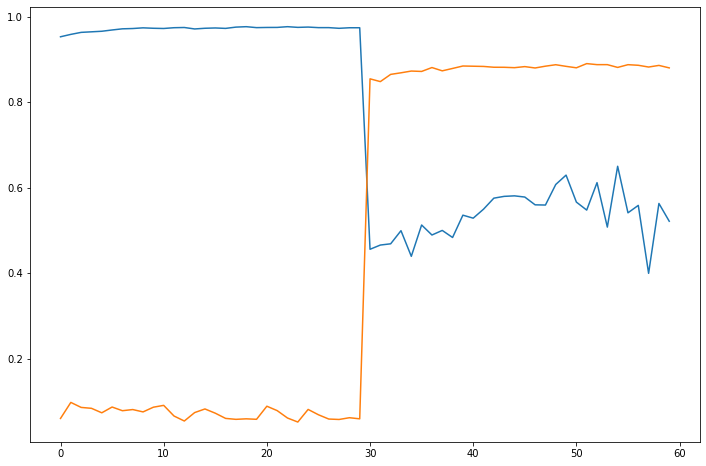

In [ ]:
import matplotlib.pyplot as plt

for meta in meta: 
  
  model = AudioClassifierBNN().to(DEVICE)
  for task in ['1', '3']:
    train_dl = ds[task]['train']
    loss, acc, test_acc, weights = train(model, train_dl, val_dl, epochs=epochs, optim='meta', meta=meta, weight_decay=1e-08)
    loss_dict[task] = loss
    acc_dict[task] = test_acc

  plt.figure(figsize=(12,8))
  plt.plot(acc_dict['1']['0']+acc_dict['3']['0'])
  plt.plot(acc_dict['1']['1']+acc_dict['3']['1'])

  plt.savefig(f'plot_meta_{meta}.png')

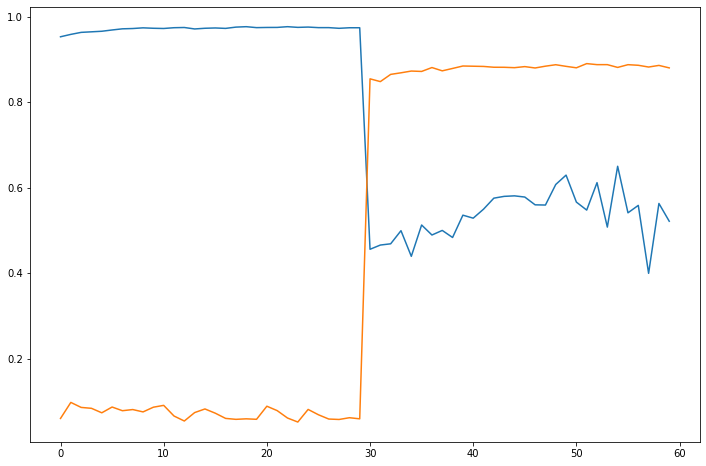

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(acc_dict['1']['0']+acc_dict['3']['0'])
plt.plot(acc_dict['1']['1']+acc_dict['3']['1'])
plt.show()
plt.savefig(f'plot_meta_{meta}.png')

In [ ]:
!cp plot_* drive/MyDrive

In [ ]:
! git init .

Initialized empty Git repository in /content/.git/


In [ ]:
!git clone https://github.com/Laborieux-Axel/SynapticMetaplasticityBNN.git

Cloning into 'SynapticMetaplasticityBNN'...
remote: Enumerating objects: 235, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 235 (delta 96), reused 91 (delta 91), pack-reused 136
Receiving objects: 100% (235/235), 189.45 KiB | 27.06 MiB/s, done.
Resolving deltas: 100% (137/137), done.


In [ ]:
! cp /content/SynapticMetaplasticityBNN/requirements.txt requirements.txt 

In [ ]:
! pip install requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement requirements.txt (from versions: none)
ERROR: No matching distribution found for requirements.txt


In [ ]:
!python /content/SynapticMetaplasticityBNN/Continual_Learning_Fig-2abcdefgh-3abcd-5cde/main.py --net 'bnn' --hidden-layers 4096 4096 --lr 0.005 --decay 1e-7 --meta 0.0 --epochs-per-task 40 --task-sequence 'pMNIST' 'pMNIST' 'pMNIST' 'pMNIST' 'pMNIST' 'pMNIST'  

100% 9912422/9912422 [00:00<00:00, 196452858.00it/s]
Extracting ./mnist_pytorch/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_pytorch/MNIST/raw

100% 28881/28881 [00:00<00:00, 146831144.03it/s]
Extracting ./mnist_pytorch/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_pytorch/MNIST/raw

100% 1648877/1648877 [00:00<00:00, 205000337.82it/s]
Extracting ./mnist_pytorch/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_pytorch/MNIST/raw

100% 4542/4542 [00:00<00:00, 29353665.28it/s]
Extracting ./mnist_pytorch/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_pytorch/MNIST/raw

100% 26421880/26421880 [00:01<00:00, 19612733.39it/s]
Extracting ./fmnist_pytorch/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fmnist_pytorch/FashionMNIST/raw

100% 29515/29515 [00:00<00:00, 326871.02it/s]
Extracting ./fmnist_pytorch/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fmnist_pytorch/FashionMNIST/raw

100% 4422102/4422102 [00:00<00:00, 6235898.98it/s]
Extracting ./fmnist_pytorch/FashionMNIST/raw/t10k-imag

In [ ]:
!python /content/SynapticMetaplasticityBNN/Continual_Learning_Fig-2abcdefgh-3abcd-5cde/main.py --net 'bnn' --hidden-layers 4096 4096 --lr 0.005 --decay 1e-7 --meta 1.35 --epochs-per-task 40 --task-sequence 'pMNIST' 'pMNIST' 'pMNIST' 'pMNIST' 'pMNIST' 'pMNIST'  


BNN(
  (layers): ModuleDict(
    (fc1): BinarizeLinear(in_features=784, out_features=4096, bias=False)
    (bn1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): BinarizeLinear(in_features=4096, out_features=4096, bias=False)
    (bn2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc3): BinarizeLinear(in_features=4096, out_features=10, bias=False)
    (bn3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
/content/SynapticMetaplasticityBNN/Continual_Learning_Fig-2abcdefgh-3abcd-5cde/models_utils.py:370: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)
  grad.add_(group['weight_decay'], p.data)
Test accuracy: 57851/60000 (96.42%)
Test accuracy: 9582/10000 (95.82%)
